In [21]:
import pandas as pd
import math
from statistics import mean
from math import log
import joblib
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report,  RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from tqdm import tqdm
from IPython.display import display
tqdm.pandas()
plt.style.use('seaborn-darkgrid')

In [22]:
data_path = "./Data/Other DNS Exfiltration Tools/"

Queries from other DNS Exfiltration tools obtained from https://data.mendeley.com/datasets/mzn9hvdcxg/1 and the corresponding repo https://github.com/netrack/learn/tree/master/dns

In [24]:
dns2tcp = (pd.read_csv(data_path + "dns2tcp.csv")[["label", "qname"]]).rename(columns={'qname': "query"})
dnscapy = (pd.read_csv(data_path + "dnscapy.csv")[["label", "qname"]]).rename(columns={'qname': "query"})
iodine = (pd.read_csv(data_path + "iodine.csv")[["label", "qname"]]).rename(columns={'qname': "query"})
tuns = (pd.read_csv(data_path + "tuns.csv")[["label", "qname"]]).rename(columns={'qname': "query"})
plain = (pd.read_csv(data_path + "plain.csv")[["label", "qname"]]).rename(columns={'qname': "query"})

In [25]:
dns2tcp

,label,query
0,1,q+Z8AnwaBA.hidemyself.org.
1,1,q+Z78HwICAmzS43DljePoV/By/7Gotp+J5ntO9EwInkaB2...
2,1,q+Z78XwJBA.hidemyself.org.
3,1,q+Z8A3wbBA.hidemyself.org.
4,1,q+Z78nwKCFN/KiVKt6y82B7420xjjUHXbSEZu6m0XvlxnG...
...,...,...
9065,1,q+aNuI3QCIPhzk61N9XU71DSyUcQmvS5tCJA3ulJxUQPie...
9066,1,q+aNuY3RCK1dEJL0T+ZNO+CZee/ENcOednx70b9Mi98wwg...
9067,1,q+aNuo3SCJ8wYXIb3lUmSCecugon18v2muUcypuYIoEEa/...
9068,1,q+aNo427CP6cx8Ce9V07UYHC4w2VYLJuNKdC2nMgIEbgAN...


In [26]:
#df = pd.concat([df_train, df_val])
df = pd.concat([
    dns2tcp,
    dnscapy,
    iodine,
    tuns,
    plain
])

In [27]:
plain

,label,query
0,0,google.com.
1,0,google.com.
2,0,facebook.com.
3,0,facebook.com.
4,0,doubleclick.net.
...,...,...
17274,0,zpfdtwgyfq.biz.
17275,0,zpfdtwgyfq.biz.
17276,0,nortel.com.
17277,0,nortel.com.


In [28]:
df["attack"] = df["label"].apply(lambda x:1 if x > 0 else 0)

In [29]:
def get_origin(x):
    if x==1:
        return "dns2tcp"
    elif x==2:
        return "dnscapy"
    elif x==3:
        return "iodine"
    elif x==4:
        return "tuns"
    elif x==0:
        return "benign"
    
df["origin"] = df["label"].apply(get_origin)

In [30]:
df[df.attack==0].sample(5)

,label,query,attack,origin
13244,0,forbes.pl.,0,benign
7559,0,jawbone.com.,0,benign
65,0,live.com.,0,benign
13408,0,hearstdigital.com.,0,benign
2154,0,virool.com.,0,benign


In [31]:
df[df.attack==1].sample(5)

,label,query,attack,origin
72645,4,r38225.tunnel.tuns.org.,1,tuns
97927,4,dIUEABDEVPBAAAQAGSDTQUAAAAMFAAAAC37HAAFQ4GEYN7...,1,tuns
3036,4,r16508.tunnel.tuns.org.,1,tuns
54875,4,dIUEABDFNLNAAAQAGPECAUAAAAMFAAAAC37CAAFUWYSJF6...,1,tuns
123005,4,r53427.tunnel.tuns.org.,1,tuns


Since all the queries have a trailing period (.), we remove this to represent a real query.

In [32]:
df["query"].str.endswith(".").sum()/df.shape[0]

1.0

In [33]:
def preprocess_query(x):
    return x[:-1]

In [34]:
df["query"] = df["query"].apply(preprocess_query)

Validating the queries are not invalid based on splitting dots:

In [35]:
df["query"].apply(lambda x: len(x.split("."))).value_counts()

4     75464
7     60346
2     16201
11    13094
5      7853
3      4477
6       750
9       223
10       18
8         4
34        4
Name: query, dtype: int64

In [36]:
df["labels"] = df["query"].apply(lambda x: len(x.split(".")))
df[df["labels"]==3]["query"].iloc[-1]

'lasa.com.br'

In [37]:
".".join(('d.e.1.4168.tunnel.example.org').split(".")[:-2])

'd.e.1.4168.tunnel'

In [38]:
".".join(("google.com").split(".")[:-2])

''

# Extracting all the required stateless features for the models by Mahdavifar et al.

In [39]:
# Code adapted from https://stackoverflow.com/questions/2979174/how-do-i-compute-the-approximate-entropy-of-a-bit-string

def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy


# Code adapted from https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
# Build a cost dictionary, assuming Zipf's law and cost = -math.log(probability).
words = open(data_path+"words-by-frequency.txt").read().split()
wordcost = dict((k, log((i+1)*log(len(words)))) for i,k in enumerate(words))
maxword = max(len(x) for x in words)
def infer_spaces(s):
    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return " ".join(reversed(out))

def extract_features(row):
    labels = row["query"].split(".")

    row["FQDN_count"] = len(row)
    row["subdomain"] = len(labels) >= 2
    if row["subdomain"]:
        subdomain = ".".join((row["query"]).split(".")[:-2])
    else:
        subdomain = ""
    row["subdomain_length"] = len(subdomain)
    upper, lower, numeric, special = 0, 0, 0, 0
    for c in row["query"]:
        if c.islower():
            lower += 1
        if c.isupper():
            upper += 1
        if c.isnumeric():
            numeric += 1
        if not c.isalnum():
            special += 1
    row["lower"] = lower
    row["upper"] = upper
    row["numeric"] = numeric
    row["special"] = special
    row["entropy"] = entropy(row["query"])
    row["labels"] = len(labels)
    row["labels_max"] = max([len(label) for label in labels])
    row["labels_average"] = mean([len(label) for label in labels])
    row["sld"] = labels[-2]
    row["len"] = row["subdomain_length"] + len(labels[-2])
    extracted_words = []
    for label in labels:
        extracted_words += (infer_spaces(''.join(filter(str.isalpha, label)))).split()
    row["longest_word"] = max(extracted_words, key=len)
    return row


In [40]:
#df = df.sample(1000, random_state=0)
feature_extraction_start_time = time.time()
df = df.progress_apply(extract_features, axis=1)
feature_extraction_end_time = time.time()

100%|█████████████████████████████████████████████████████████████████████████| 178434/178434 [23:17<00:00, 127.69it/s]


In [41]:
feature_extraction_total_time = feature_extraction_end_time - feature_extraction_start_time
print(f"Time taken to extract features from the data: {feature_extraction_total_time:.3f} for {df.shape[0]} queries")
per_query_extraction_time = feature_extraction_total_time/df.shape[0]
print(f"Time taken to extract features per query: {per_query_extraction_time:.3f}")

Time taken to extract features from the data: 1397.423 for 178434 queries
Time taken to extract features per query: 0.008


In [42]:
df.to_csv(data_path+"other_dns_exfiltraion_tools_with_extracted_features.csv", index=None)

In [43]:
# Use if starting from saved data:
df = pd.read_csv(data_path+"other_dns_exfiltraion_tools_with_extracted_features.csv")

# Load saved models:

## LR Model baseline

In [45]:
lr_baseline_column_transformer = joblib.load('models/lr_baseline_column_transformer.pkl')
lr_baseline_model = joblib.load('models/lr_baseline_model.pkl')

## RF Model baseline

In [46]:
rf_baseline_column_transformer = joblib.load('models/rf_baseline_column_transformer.pkl')
rf_baseline_model = joblib.load('models/rf_baseline_model.pkl')

# Evaluating the models on the queries from other DNS tools:

## Baseline LR

In [47]:
X = df[[col for col in df.columns if col != "attack"]]
y = df[["attack"]]

X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())

X = lr_baseline_column_transformer.transform(X)
predictions = lr_baseline_model.predict(X)
df["predictions"] = predictions

for origin in df.origin.unique():
    subset = df[df.origin==origin]
    print("Origin: ", origin)
    display(pd.DataFrame(classification_report(subset["attack"],  subset["predictions"], output_dict=True)).T)

Origin:  dns2tcp


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.637045,0.778287,9070.000000
accuracy,0.637045,0.637045,0.637045,0.637045
macro avg,0.500000,0.318523,0.389143,9070.000000
weighted avg,1.000000,0.637045,0.778287,9070.000000


Origin:  dnscapy


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.923733,0.960355,14423.000000
accuracy,0.923733,0.923733,0.923733,0.923733
macro avg,0.500000,0.461866,0.480177,14423.000000
weighted avg,1.000000,0.923733,0.960355,14423.000000


Origin:  iodine


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.987815,0.993870,12228.000000
accuracy,0.987815,0.987815,0.987815,0.987815
macro avg,0.500000,0.493907,0.496935,12228.000000
weighted avg,1.000000,0.987815,0.993870,12228.000000


Origin:  tuns


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.398616,0.570015,125434.000000
accuracy,0.398616,0.398616,0.398616,0.398616
macro avg,0.500000,0.199308,0.285007,125434.000000
weighted avg,1.000000,0.398616,0.570015,125434.000000


Origin:  benign


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,0.998843,0.999421,17279.000000
1,0.000000,0.000000,0.000000,0.000000
accuracy,0.998843,0.998843,0.998843,0.998843
macro avg,0.500000,0.499421,0.499710,17279.000000
weighted avg,1.000000,0.998843,0.999421,17279.000000


## Baseline RF

In [48]:
X = df[[col for col in df.columns if col != "attack"]]
# X = df[['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
#        'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len',
#        'subdomain']]
y = df[["attack"]]

# X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
# X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
# X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
# X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())

X = rf_baseline_column_transformer.transform(X)
predictions = rf_baseline_model.predict(X)
df["predictions"] = predictions

for origin in df.origin.unique():
    subset = df[df.origin==origin]
    print("Origin: ", origin)
    display(pd.DataFrame(classification_report(subset["attack"],  subset["predictions"], output_dict=True)).T)

Origin:  dns2tcp


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,9070.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,9070.0
weighted avg,0.0,0.0,0.0,9070.0


Origin:  dnscapy


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,14423.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,14423.0
weighted avg,0.0,0.0,0.0,14423.0


Origin:  iodine


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12228.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,12228.0
weighted avg,0.0,0.0,0.0,12228.0


Origin:  tuns


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,125434.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,125434.0
weighted avg,0.0,0.0,0.0,125434.0


Origin:  benign


,precision,recall,f1-score,support
0,1.0,1.0,1.0,17279.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,17279.0
weighted avg,1.0,1.0,1.0,17279.0


# Using the models trained on optimized features:

## LR

In [49]:
lr_optimized_features_column_transformer = joblib.load('models/lr_optimized_features_column_transformer.pkl')
lr_optimized_features_model = joblib.load('models/lr_optimized_features_model.pkl')

In [50]:
X = df[[col for col in df.columns if col != "attack"]]
y = df[["attack"]]

X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())

X = lr_optimized_features_column_transformer.transform(X)
predictions = lr_optimized_features_model.predict(X)
df["predictions"] = predictions

for origin in df.origin.unique():
    subset = df[df.origin==origin]
    print("Origin: ", origin)
    display(pd.DataFrame(classification_report(subset["attack"],  subset["predictions"], output_dict=True)).T)

Origin:  dns2tcp


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.648732,0.786947,9070.000000
accuracy,0.648732,0.648732,0.648732,0.648732
macro avg,0.500000,0.324366,0.393473,9070.000000
weighted avg,1.000000,0.648732,0.786947,9070.000000


Origin:  dnscapy


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.924842,0.960954,14423.000000
accuracy,0.924842,0.924842,0.924842,0.924842
macro avg,0.500000,0.462421,0.480477,14423.000000
weighted avg,1.000000,0.924842,0.960954,14423.000000


Origin:  iodine


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.988633,0.994284,12228.000000
accuracy,0.988633,0.988633,0.988633,0.988633
macro avg,0.500000,0.494316,0.497142,12228.000000
weighted avg,1.000000,0.988633,0.994284,12228.000000


Origin:  tuns


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,1.000000,0.398616,0.570015,125434.000000
accuracy,0.398616,0.398616,0.398616,0.398616
macro avg,0.500000,0.199308,0.285007,125434.000000
weighted avg,1.000000,0.398616,0.570015,125434.000000


Origin:  benign


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,0.998843,0.999421,17279.000000
1,0.000000,0.000000,0.000000,0.000000
accuracy,0.998843,0.998843,0.998843,0.998843
macro avg,0.500000,0.499421,0.499710,17279.000000
weighted avg,1.000000,0.998843,0.999421,17279.000000


## RF

In [51]:
rf_optimized_features_column_transformer = joblib.load('models/rf_optimized_features_column_transformer.pkl')
rf_optimized_features_model = joblib.load('models/rf_optimized_features_model.pkl')

In [52]:
X = df[[col for col in df.columns if col != "attack"]]
y = df[["attack"]]

X["longest_word_islower"] = X["longest_word"].apply(lambda x: str(x).islower())
X["longest_word_isnumeric"] = X["longest_word"].apply(lambda x: str(x).isnumeric())
X["sld_islower"] = X["sld"].apply(lambda x: str(x).islower())
X["sld_isnumeric"] = X["sld"].apply(lambda x: str(x).isnumeric())

X = rf_optimized_features_column_transformer.transform(X)
predictions = rf_optimized_features_model.predict(X)
df["predictions"] = predictions

for origin in df.origin.unique():
    subset = df[df.origin==origin]
    print("Origin: ", origin)
    display(pd.DataFrame(classification_report(subset["attack"],  subset["predictions"], output_dict=True)).T)

Origin:  dns2tcp


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,9070.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,9070.0
weighted avg,0.0,0.0,0.0,9070.0


Origin:  dnscapy


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,14423.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,14423.0
weighted avg,0.0,0.0,0.0,14423.0


Origin:  iodine


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12228.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,12228.0
weighted avg,0.0,0.0,0.0,12228.0


Origin:  tuns


D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python 3.10\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarn

,precision,recall,f1-score,support
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,125434.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,125434.0
weighted avg,0.0,0.0,0.0,125434.0


Origin:  benign


,precision,recall,f1-score,support
0,1.0,1.0,1.0,17279.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,17279.0
weighted avg,1.0,1.0,1.0,17279.0


Both baseline and optimized logistic regression models perform well on all the tools except tuns. Both Random forest models are unable to classify any of the queries from other DNS Exfiltration tools.

# Training on queries from other DNS Exfiltration tools:

In [53]:
original_stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")
other_queries_df = df.copy()

In [54]:
optimized_features = ['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'special',
       'labels', 'longest_word_islower',
       'longest_word_isnumeric', 'sld_islower', 'sld_isnumeric']

In [55]:
for df in [original_stateless_df, other_queries_df]:
    df["longest_word_islower"] = df["longest_word"].apply(lambda x: str(x).islower())
    df["longest_word_isnumeric"] = df["longest_word"].apply(lambda x: str(x).isnumeric())
    df["sld_islower"] = df["sld"].apply(lambda x: str(x).islower())
    df["sld_isnumeric"] = df["sld"].apply(lambda x: str(x).isnumeric())

In [56]:
original_stateless_df = original_stateless_df[optimized_features + ["attack"]]
other_queries_df = other_queries_df[optimized_features + ["attack"]]
combined_df = pd.concat([original_stateless_df, other_queries_df]).reset_index()

In [57]:
combined_df.sample(20)

,index,FQDN_count,subdomain_length,lower,numeric,special,labels,longest_word_islower,longest_word_isnumeric,sld_islower,sld_isnumeric,attack
527437,527437,24,7,10,8,6,6,False,True,False,True,1
490934,490934,25,8,10,9,6,6,False,True,False,True,1
418731,418731,27,10,10,11,6,6,False,True,False,True,0
474415,474415,25,8,10,9,6,6,False,True,False,True,1
455816,455816,21,0,18,0,3,2,True,False,True,False,0
252164,252164,27,0,25,0,2,2,True,False,True,False,0
731958,731958,24,7,10,8,6,6,False,True,False,True,1
303025,303025,26,9,10,10,6,6,False,True,False,True,0
557043,557043,25,8,10,9,6,6,False,True,False,True,1
834541,77330,5,235,14,32,6,7,True,False,True,False,1


# Reduced Feature LR

Fold  1
Train Accuracy: 0.7976195565625852
Test Accuracy: 0.7811242511850114
Fold  2
Train Accuracy: 0.7999254524953374
Test Accuracy: 0.7708532616537255
Fold  3
Train Accuracy: 0.7954125229120019
Test Accuracy: 0.7899096345301904
Fold  4
Train Accuracy: 0.7983142644913402
Test Accuracy: 0.7925762441951809
Fold  5
Train Accuracy: 0.7919710467110923
Test Accuracy: 0.8218287919029119


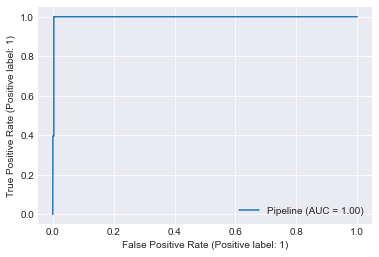

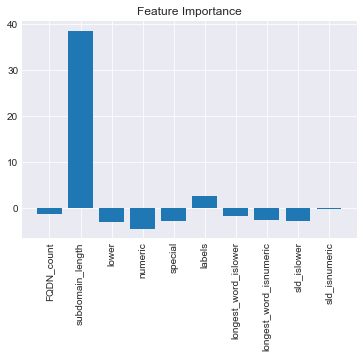

,precision,recall,f1-score,support
0,0.963385,0.616661,0.751981,480137.000000
1,0.707063,0.975296,0.819796,455508.000000
accuracy,0.791258,0.791258,0.791258,0.791258
macro avg,0.835224,0.795979,0.785889,935645.000000
weighted avg,0.838598,0.791258,0.784996,935645.000000


In [58]:



X = combined_df[optimized_features]
y = combined_df["attack"]


skf = StratifiedKFold(n_splits=5)
#stateless_df = pd.read_csv("stateless.csv")
#stateless_df = stateless_df.fillna("")
combined_df["Predictions"] = 0
#features_to_use_directly = [col for col in stateless_df.columns if col in selector.get_feature_names_out()]
#features_to_compute = [feature for feature in selector.get_feature_names_out() if feature not in features_to_use_directly]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    print("Fold ", (i+1))
    #print(X_train)
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), optimized_features)
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('lr', LogisticRegression(random_state=0, max_iter=300))
    ])    
    pipe.fit(X_train, y_train)
    
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    combined_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)

    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
importance = pipe["lr"].coef_[0]

plt.bar(optimized_features, importance)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()
display(pd.DataFrame(classification_report(combined_df["attack"], combined_df["Predictions"], output_dict=True)).T)


                
    

In [59]:
joblib.dump(category_pipeline, "models/lr_other_dns_tools_column_transformer.pkl")
joblib.dump(pipe, 'models/lr_other_dns_tools_model.pkl')

['lr_other_dns_tools_model.pkl']

## Reduced Feature RF

Fold  1
Train Accuracy: 0.80179982792619
Test Accuracy: 0.7916731238877993
Fold  2
Train Accuracy: 0.804458421730464
Test Accuracy: 0.7811135633707229
Fold  3
Train Accuracy: 0.7998199103292382
Test Accuracy: 0.7996355455327608
Fold  4
Train Accuracy: 0.7998052145845914
Test Accuracy: 0.7082387016443202
Fold  5
Train Accuracy: 0.7931680819114088
Test Accuracy: 0.8217272576671708


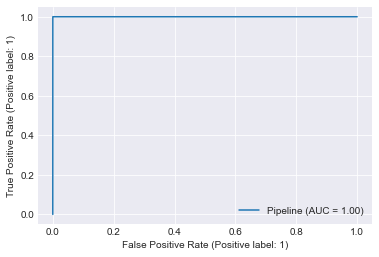

,precision,recall,f1-score,support
0,0.943456,0.608697,0.739977,480137.000000
1,0.699812,0.961546,0.810062,455508.000000
accuracy,0.780478,0.780478,0.780478,0.780478
macro avg,0.821634,0.785122,0.775020,935645.000000
weighted avg,0.824840,0.780478,0.774097,935645.000000


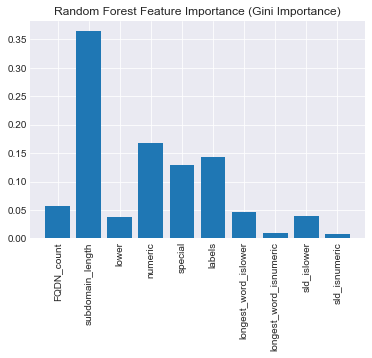

['rf_other_dns_tools_model.pkl']

In [60]:



X = combined_df[optimized_features]
y = combined_df["attack"]


skf = StratifiedKFold(n_splits=5)
#stateless_df = pd.read_csv("stateless.csv")
#stateless_df = stateless_df.fillna("")
combined_df["Predictions"] = 0
#features_to_use_directly = [col for col in stateless_df.columns if col in selector.get_feature_names_out()]
#features_to_compute = [feature for feature in selector.get_feature_names_out() if feature not in features_to_use_directly]
trained_pipes_lr = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    print("Fold ", (i+1))
    #print(X_train)
    category_pipeline = ColumnTransformer(
    [
     #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), optimized_features)
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])    
    pipe.fit(X_train, y_train)
    
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    combined_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)

    trained_pipes_lr.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

    
lr_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    

display(pd.DataFrame(classification_report(combined_df["attack"], combined_df["Predictions"], output_dict=True)).T)

# get importance
importance = pipe["rf"].feature_importances_
# plot feature importance
plt.bar(optimized_features, importance)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance (Gini Importance)")
plt.show()    
                
joblib.dump(category_pipeline, "models/rf_other_dns_tools_column_transformer.pkl")
joblib.dump(pipe, 'models/rf_other_dns_tools_model.pkl') 